In [1]:
import csv
import numpy as np
import pandas as pd
import scipy.signal as signal
from scipy.signal import find_peaks, peak_widths, peak_prominences, find_peaks_cwt, argrelextrema
from tqdm.notebook import tqdm, trange
# bokeh plot settings
from bokeh.io import output_notebook, show, save
output_notebook()
from bokeh.models import ColumnDataSource, HoverTool, Scatter
from bokeh.plotting import figure
from bokeh.sampledata.autompg import autompg_clean
from bokeh.transform import factor_cmap
from bokeh.layouts import gridplot
from bokeh.palettes import brewer
from lmfit.models import GaussianModel, LinearModel, ExponentialModel

Loading BokehJS ...

In [2]:
# Path: tests/peak_detect.ipynb
import os
# find root directory
root = os.path.dirname(os.path.abspath('./'))
# append root directory to sys.path
import sys
sys.path.append(root)

# Read data and pre-process

In [3]:
from tools.get_files import GetFiles
from tools.read_mzxml import read_mzxml


file_finder = GetFiles('/mnt/d/Data/LTQ数据/', 'mzXML')
file_list = file_finder.get_files()
xml_data_list = []
filename_list = []
for file in file_list:
    filename_list.append(file.split('/')[-1])
    xml_data_list.append([read_mzxml(file, env='Production')])

100%|██████████| 57/57 [00:00<00:00, 2905.77it/s]
/home/gakkispy/Code/overlap_project/tools/read_mzxml.py:64: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  point_list = np.array(point_list)
100%|██████████| 56/56 [00:00<00:00, 2243.20it/s]


In [4]:
def get_mass_spectrum(data):
    """
    Get the mass spectrum of a specific mass from the data.
    """
    spectrum_list = []
    for i in range(len(data)):
        spectrum = pd.DataFrame({'mz': data[i][0::2], 'intensity': data[i][1::2]},)
        spectrum_list.append(spectrum)
    return spectrum_list

In [5]:
from findpeaks import findpeaks
from scipy.optimize import curve_fit

def plot_peak_fit(p, peak_index, peak_height, data, title:str):
    p.scatter(data['mz'][peak_index], peak_height, size=5, color='darkcyan')
    return p

def plot_valley_fit(p, valley_index, valley_height, data, title:str):
    p.star(data['mz'][valley_index], valley_height, size=5, color='darkcyan')
    return p

In [6]:
# handle peak fit reuslt
def peak_fit_result(result, data):
    df = result['df']
    df['x'] = data['mz']
    peak_index= df[lambda df: df['peak'] == True]
    highest_peak = df.loc[peak_index.index.tolist()]['y'].max()
    peak_index_list = peak_index[lambda peak_index: peak_index['y'] > .1 * highest_peak].index.tolist()
    valley_index = df[lambda df: df['valley'] == True]
    valley_index_list = valley_index[lambda valley_index: valley_index['y'] > .1 * highest_peak].index.tolist()
    print('peak index: ', peak_index_list)
    # print('valley index: ', valley_index_list)
    return peak_index_list, valley_index_list

In [ ]:
file_data_dict = dict(zip(filename_list, xml_data_list))
spectrums_list = []
for key, value in file_data_dict.items():
    point_list = value[0][0]
    spectrum_list = get_mass_spectrum(point_list)
    spectrums_list.append(spectrum_list)

file_spectrum_dict = dict(zip(filename_list, spectrums_list))

for key, value in tqdm(file_spectrum_dict.items()):
    save_dir = '/mnt/d/Data/LTQ数据/' + os.path.splitext(key)[0] + '/'
    if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    for id, spectrum in tqdm(enumerate(value)):
        exp_mod = ExponentialModel(prefix='exp_')
        pars = exp_mod.guess(spectrum['intensity'], x=spectrum['mz'])
        gauss_dict = dict()
        fp = findpeaks(method='topology', interpolate=5, lookahead=10, limit=5, verbose=False)
        mod = exp_mod
        p = figure(title=key, plot_width=1440, plot_height=720)
        # 设定寻峰规则，寻找m/z轴顶峰
        try:
            fp_result = fp.fit(spectrum["intensity"])
            peak_index, valley_index = peak_fit_result(fp_result, spectrum)
        except Exception as e:
            # print(e)
            continue
        max_peak = spectrum['intensity'][peak_index].max()
        if peak_index:
            # 对峰的部分用guass拟合
            for index, peak in tqdm(enumerate(peak_index)):
                print('index: {}, peak location: {}'.format(index, spectrum['mz'][peak_index]))
                tmp_prefix = 'pcm' + str(index) + '_'
                gauss_dict[tmp_prefix] = GaussianModel(prefix=tmp_prefix)
                pars.update(gauss_dict['pcm'+str(index)+'_'].make_params())
                pars[tmp_prefix+'center'].set(spectrum["mz"][peak] , min=spectrum["mz"][peak] - 50, max= spectrum["mz"][peak] + 50)
                pars[tmp_prefix+'amplitude'].set(5, max = max_peak, min=0.1)
                pars[tmp_prefix+'sigma'].set(10, min=0.1, max=50)
                mod += gauss_dict[tmp_prefix]
            out = mod.fit(spectrum["intensity"], pars, x=spectrum['mz'])
            # break
            comps = out.eval_components(x=spectrum["mz"])
            for i in range(len(peak_index)):
                p.line(spectrum["mz"], comps['pcm' + str(i) + '_'], legend_label= f'gaussian peak no {index}', line_width=2, color=brewer['Spectral'][11][i])
            p = plot_peak_fit(p, peak_index, spectrum['intensity'][peak_index], spectrum, key)
            p = plot_valley_fit(p, valley_index, spectrum['intensity'][peak_index], spectrum, key)
           
        p.line(spectrum['mz'], spectrum['intensity'], line_width=2, line_dash = (4,4), color='darkcyan')
        save(p, filename='{}.html'.format(save_dir + str(id)))

In [ ]:
file_data_dict = dict(zip(filename_list, xml_data_list))
spectrums_list = []
for key, value in file_data_dict.items():
    point_list = value[0][0]
    spectrum_list = get_mass_spectrum(point_list)
    spectrums_list.append(spectrum_list)

file_spectrum_dict = dict(zip(filename_list, spectrums_list))

for key, value in tqdm(file_spectrum_dict.items()):
    save_dir = '/mnt/d/Data/LTQ数据/' + os.path.splitext(key)[0] + '/'
    if not os.path.exists(save_dir):
            os.makedirs(save_dir)
    for id, spectrum in tqdm(enumerate(value)):
        exp_mod = ExponentialModel(prefix='exp_')
        pars = exp_mod.guess(spectrum['intensity'], x=spectrum['mz'])
        gauss_dict = dict()
        fp = findpeaks(method='topology', interpolate=5, lookahead=10, limit=5, verbose=False)
        mod = exp_mod
        p = figure(title=key, plot_width=1440, plot_height=720)
        # 设定寻峰规则，寻找m/z轴顶峰
        try:
            fp_result = fp.fit(spectrum["intensity"])
            peak_index, valley_index = peak_fit_result(fp_result, spectrum)
        except Exception as e:
            # print(e)
            continue
        max_peak = spectrum['intensity'][peak_index].max()
        if peak_index:
            # 对峰的部分用guass拟合
            for index, peak in tqdm(enumerate(peak_index)):
                print('index: {}, peak location: {}'.format(index, spectrum['mz'][peak_index]))
                tmp_prefix = 'pcm' + str(index) + '_'
                gauss_dict[tmp_prefix] = GaussianModel(prefix=tmp_prefix)
                pars.update(gauss_dict['pcm'+str(index)+'_'].make_params())
                pars[tmp_prefix+'center'].set(spectrum["mz"][peak] , min=spectrum["mz"][peak] - 50, max= spectrum["mz"][peak] + 50)
                pars[tmp_prefix+'amplitude'].set(5, max = max_peak, min=0.1)
                pars[tmp_prefix+'sigma'].set(10, min=0.1, max=50)
                mod += gauss_dict[tmp_prefix]
            out = mod.fit(spectrum["intensity"], pars, x=spectrum['mz'])
            # break
            comps = out.eval_components(x=spectrum["mz"])
            for i in range(len(peak_index)):
                p.line(spectrum["mz"], comps['pcm' + str(i) + '_'], legend_label= f'gaussian peak no {index}', line_width=2, color=brewer['Spectral'][11][i])
            p = plot_peak_fit(p, peak_index, spectrum['intensity'][peak_index], spectrum, key)
            p = plot_valley_fit(p, valley_index, spectrum['intensity'][peak_index], spectrum, key)
           
        p.line(spectrum['mz'], spectrum['intensity'], line_width=2, line_dash = (4,4), color='darkcyan')
        save(p, filename='{}.html'.format(save_dir + str(id)))

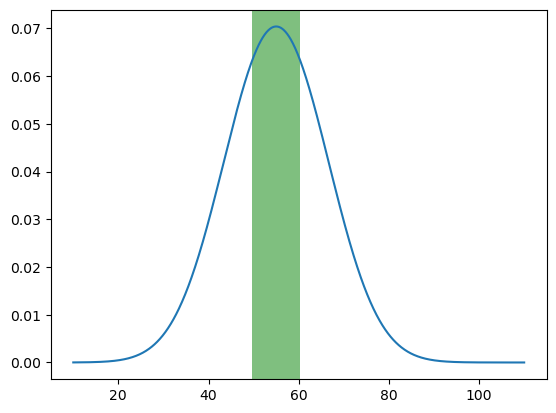

In [9]:
import numpy as np
from scipy.interpolate import UnivariateSpline

def make_norm_dist(x, mean, sd):
    return 1.0/(sd*np.sqrt(2*np.pi))*np.exp(-(x - mean)**2/(2*sd**2))

x = np.linspace(10, 110, 1000)
green = make_norm_dist(x, 50, 10)
pink = make_norm_dist(x, 60, 10)

blue = green + pink   

# create a spline of x and blue-np.max(blue)/2 
spline = UnivariateSpline(x, blue-np.max(blue)/10*9, s=0)
r1, r2 = spline.roots() # find the roots

import pylab as pl
pl.plot(x, blue)
pl.axvspan(r1, r2, facecolor='g', alpha=0.5)
pl.show()